Season
autumn    68.574167
spring    62.712083
summer    44.761667
winter    51.572917
Name: O3mean, dtype: float64


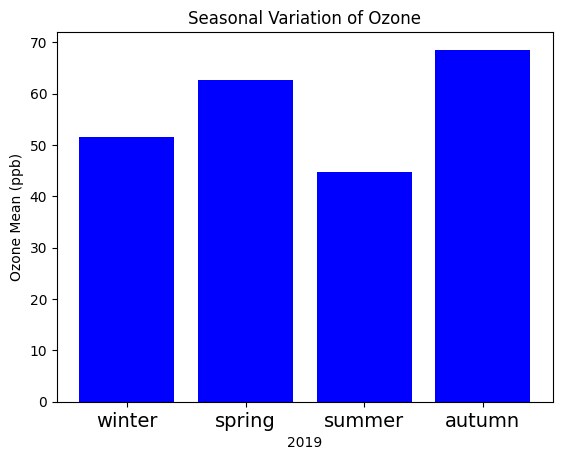

In [1]:
import pandas as pd
from datetime import date, datetime
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import numpy as np

df = pd.read_csv('SLCP2019daily.csv', index_col='Tstamp' , parse_dates = True)
df = df[(df['BCmean'] >= 0) & (df['PM2.5mean'] >=0)]

Y = 2019
seasons = [('winter', (date(Y,1,1), date(Y,3,20))),
           ('spring', (date(Y,3,21), date(Y,6,20))),
           ('summer', (date(Y,6,21), date(Y,9,22))),
           ('autumn', (date(Y,9,23), date(Y,12,20))),
           ('winter', (date(Y,12,21), date(Y,12,31)))]
i=0
#seasontype = pd.Series([])
df['Date'] = df.index
df['Season'] = np.nan
def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    #now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= now <= end)
#print(get_season(max_slcp['Date'][200]))
for i in range(len(df)):
    df.iloc[i,18] = get_season(df.iloc[i, 17])

seasonal_mean = df.groupby('Season')['O3mean'].max()
print(seasonal_mean)

plt.bar(['winter', 'spring', 'summer', 'autumn'], [51.57291667, 62.71208333, 44.76166667,68.57416667], color='blue')
plt.xticks(seasonal_mean.index, fontsize=14)
plt.xticks(seasonal_mean.index, fontsize=14)
plt.xlabel('2019')
plt.ylabel('Ozone Mean (ppb)')
plt.title('Seasonal Variation of Ozone')
plt.show()

In [3]:
# Fill missing values
df['wdir'] = df['wdir'].fillna(0)
df['wspd'] = df['wspd'].fillna(0)
df['prec'] = df['prec'].fillna(0)
df['temp'] = df['temp'].fillna(method='ffill')
df['temp'] = df['temp'].fillna(method='bfill')
df.isna().sum()

BC           0
O3           0
PM2.5        0
MERRA2-BC    0
wdir         0
wspd         0
temp         0
prec         0
dtype: int64

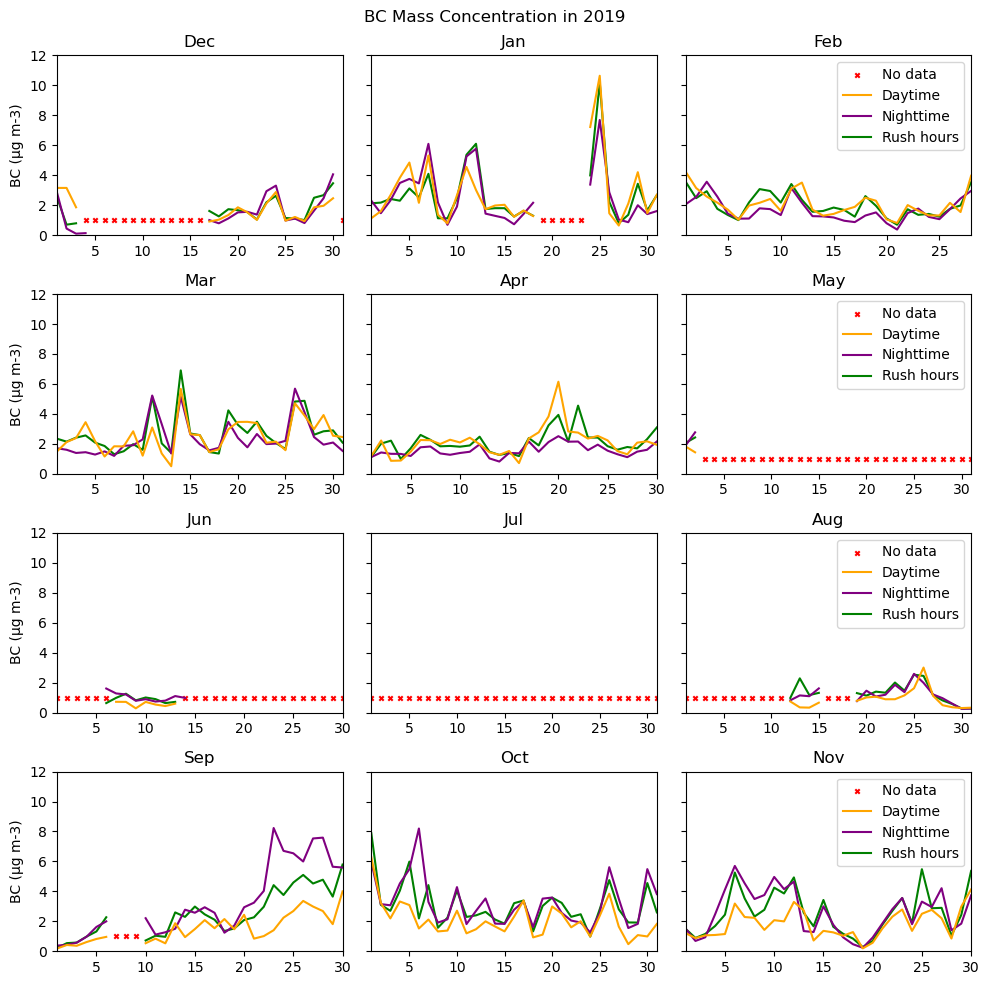

In [16]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
# metdata = pd.read_csv('data/metdata_2019-2021.csv', index_col=0, parse_dates=True)

# df = df.join(metdata)

# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()
df = pd.concat([df, bc10m], axis=1)


# Filter data
year = 2019
df = df.loc[df.index.year == year]
species = 'BC'
# df = df.dropna(subset=[species])
# df[species] = df[species].fillna(0)

# Create a dictionary of seasons and months
seasons = {'Winter': ['Dec', 'Jan', 'Feb'],
           'Spring': ['Mar', 'Apr', 'May'],
           'Summer': ['Jun', 'Jul', 'Aug'],
           'Fall': ['Sep', 'Oct', 'Nov']}

# Create subplots for each season
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

# Loop through each season and month
for i, (season, months) in enumerate(seasons.items()):
    for j, month in enumerate(months):
        # Get the data for the month
        data = df.loc[df.index.month == pd.to_datetime(month, format='%b').month]

        # Resample daily average PM2.5 for each day in the month
        daytime = data.between_time('10:00', '16:00')
        nighttime1 = data.between_time('00:00', '06:00')
        nighttime2 = data.between_time('20:00', '23:00')
        nighttime = pd.concat([nighttime1, nighttime2])
        morningrushhour = data.between_time('06:00', '09:00')
        eveningrushhour = data.between_time('17:00', '19:00')
        rushhours = pd.concat([morningrushhour, eveningrushhour])

        daytime = daytime[species].resample('D').mean()
        nighttime = nighttime[species].resample('D').mean()
        rushhours = rushhours[species].resample('D').mean()

        # Mark the nan values
        mask = daytime.isna()
        mask = mask[mask == True]  

        # Plot the data
        width = 0.3
        # p3 = axs[i][j].bar(rushhours.index.day+0.3, rushhours.values, width, label='Rush hours', color='green')
        # p2 = axs[i][j].bar(nighttime.index.day+0.6, nighttime.values, width, label='Nighttime', color='purple')
        # p1 = axs[i][j].bar(daytime.index.day, daytime.values, width, label='Daytime', color='orange')

        p3 = axs[i][j].plot(rushhours.index.day, rushhours.values, label='Rush hours', color='green')
        p2 = axs[i][j].plot(nighttime.index.day, nighttime.values, label='Nighttime', color='purple')
        p1 = axs[i][j].plot(daytime.index.day, daytime.values, label='Daytime', color='orange')
        
        # Plot the nan values
        axs[i][j].scatter(mask.index.day, mask, color='red', label='No data', marker='x', s=10)


        axs[i][j].set_title(month)
        if species == 'PM2.5':
            axs[i][j].set_ylim(0, 200)
        elif species == 'BC':
            axs[i][j].set_ylim(0, 12)
        # Set space between plots
        # plt.subplots_adjust(hspace=0.3, wspace=0.3)
        # Clear margins
        axs[i][j].margins(x=0)
        # axs[i][j].set_xlabel('Day')
        axs[i][0].set_ylabel(f'{species} (μg m-3)')
        axs[i][1].set_yticklabels([])
        axs[i][2].set_yticklabels([])
        # Set legend
        # axs[i][2].legend(['No data', 'Daytime', 'Nighttime'], loc='upper right')
        handles, labels = axs[i][2].get_legend_handles_labels()
        axs[i][2].legend(handles[::-1], labels[::-1], loc='upper right')

    # Set the title for each row
    # axs[i][0].set_title(season)
    
# Set title for figure
fig.suptitle(f'{species} Mass Concentration in {year}', fontsize=12)
plt.tight_layout()
plt.show()

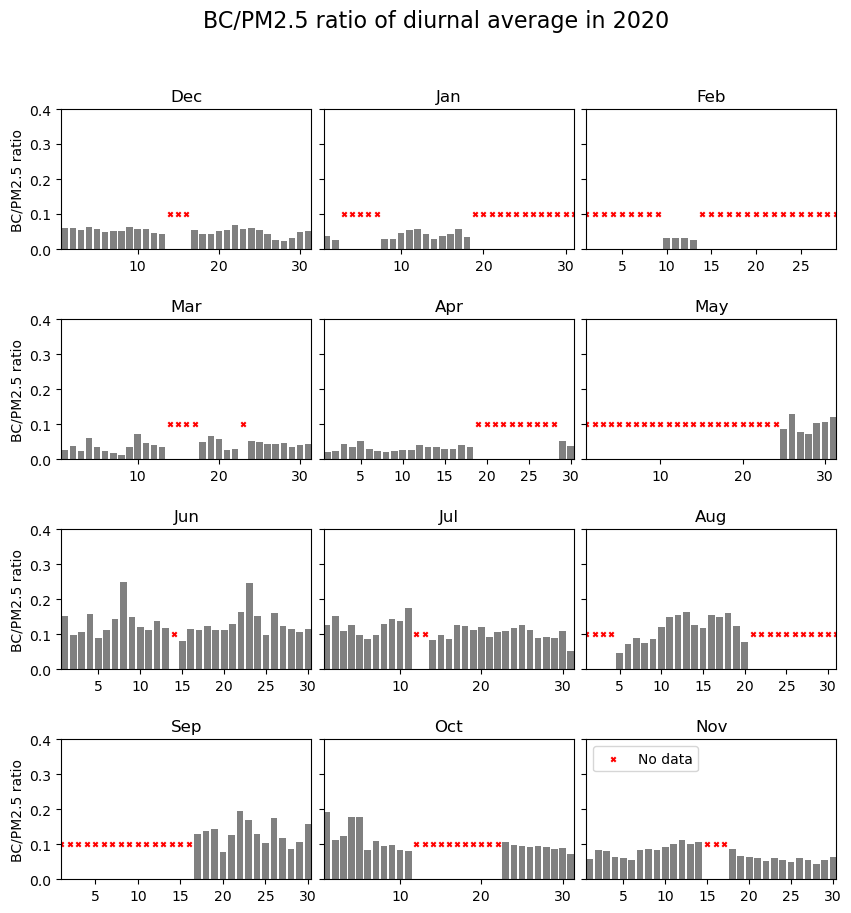

In [32]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
# metdata = pd.read_csv('data/metdata_2019-2021.csv', index_col=0, parse_dates=True)

# df = df.join(metdata)

# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()
df = pd.concat([df, bc10m], axis=1)


# Filter data
year = 2020
df = df.loc[df.index.year == year]

# Create a dictionary of seasons and months
seasons = {'Winter': ['Dec', 'Jan', 'Feb'],
           'Spring': ['Mar', 'Apr', 'May'],
           'Summer': ['Jun', 'Jul', 'Aug'],
           'Fall': ['Sep', 'Oct', 'Nov']}

# Extract BC/PM2.5 data
df['BC/PM2.5'] = df['BC']/df['PM2.5']
# df['BC/PM2.5'] = df['BC/PM2.5'].fillna(0)

# Create subplots for each season
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

# Loop through each season and month
for i, (season, months) in enumerate(seasons.items()):
    for j, month in enumerate(months):
        # Get the data for the month
        data = df.loc[df.index.month == pd.to_datetime(month, format='%b').month]
        bcpm = data['BC/PM2.5'].resample('D').mean()
        bcpm[bcpm<0.01] = None
        # Plot the data
        p1 = axs[i][j].bar(bcpm.index.day, bcpm.values, color='grey')

        # Mark the nan values
        mask = bcpm.isna()
        mask = mask[mask == True]  

        # Plot the nan values
        axs[i][j].scatter(mask.index.day, mask*0.1, color='red', label='No data', marker='x', s=10)


        axs[i][j].set_title(month)
        axs[i][j].set_ylim(0, 0.4)
        # Set space between plots
        plt.subplots_adjust(hspace=0.5, wspace=0.05)
        # Clear margins
        axs[i][j].margins(x=0)
        # axs[i][j].set_xlabel('Day')
        axs[i][0].set_ylabel('BC/PM2.5 ratio')
        axs[i][1].set_yticklabels([])
        axs[i][2].set_yticklabels([])

fig.suptitle(f'BC/PM2.5 ratio of diurnal average in {year}', fontsize=16)
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

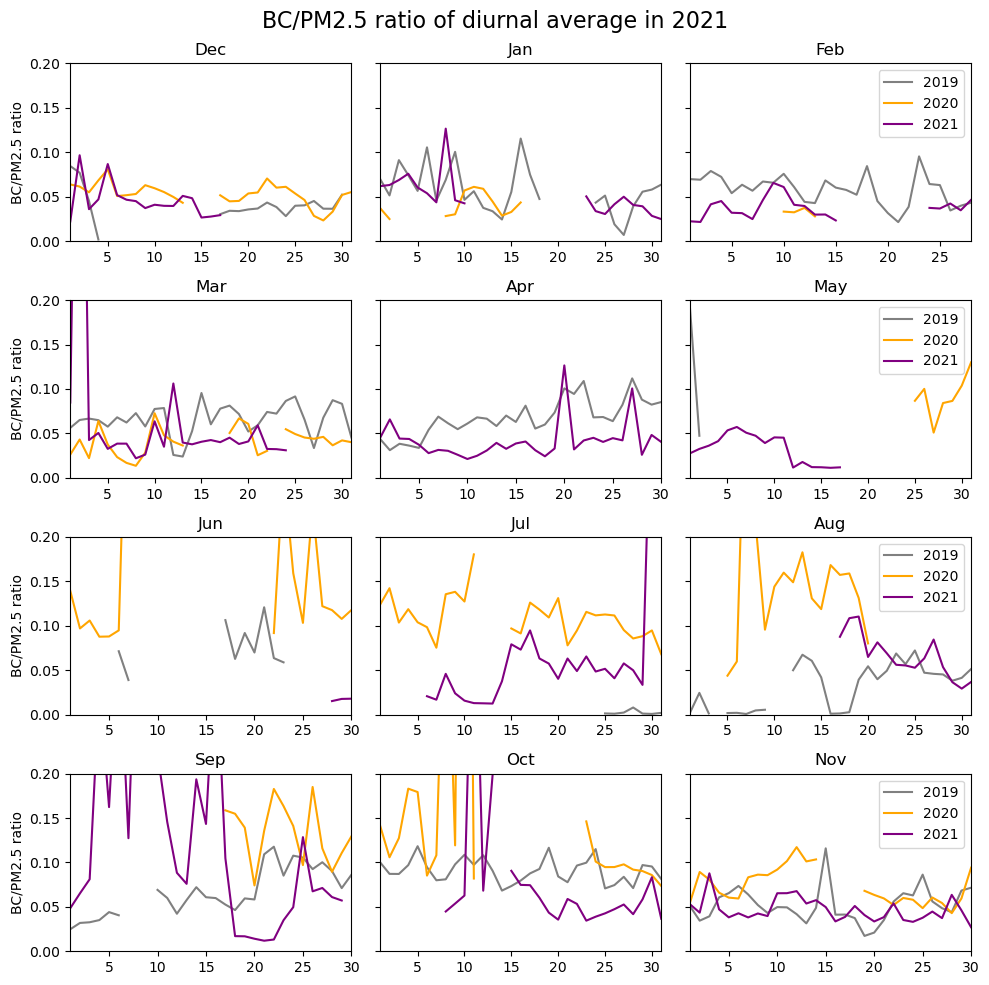

In [71]:
# Load data
import pandas as pd
df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)

# Filter data
years = [2019, 2020, 2021]
df['BC/PM2.5'] = df['BC']/df['PM2.5']
# df['BC/PM2.5'] = df['BC/PM2.5'].fillna(0)

# Create a dictionary of seasons and months
seasons = {'Winter': ['Dec', 'Jan', 'Feb'],
           'Spring': ['Mar', 'Apr', 'May'],
           'Summer': ['Jun', 'Jul', 'Aug'],
           'Fall': ['Sep', 'Oct', 'Nov']}

# Create subplots for each season
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
# Loop through each season and month
for i, (season, months) in enumerate(seasons.items()):
    for j, month in enumerate(months):            
        df19 = df.loc[df.index.year == 2019]
        df20 = df.loc[df.index.year == 2020]
        df21 = df.loc[df.index.year == 2021]
        # Get the data for the month
        data19 = df19.loc[df19.index.month == pd.to_datetime(month, format='%b').month]
        data20 = df20.loc[df20.index.month == pd.to_datetime(month, format='%b').month]
        data21 = df21.loc[df21.index.month == pd.to_datetime(month, format='%b').month]
        bcpm19 = data19['BC/PM2.5'].resample('D').mean()
        bcpm20 = data20['BC/PM2.5'].resample('D').mean()
        bcpm21 = data21['BC/PM2.5'].resample('D').mean()
        # Plot the data
        p19 = axs[i][j].plot(bcpm19.index.day, bcpm19.values, color='grey', label='2019')
        p20 = axs[i][j].plot(bcpm20.index.day, bcpm20.values, color='orange', label='2020')
        p21 = axs[i][j].plot(bcpm21.index.day, bcpm21.values, color='purple', label='2021')
        axs[i][j].set_title(month)
        axs[i][j].set_ylim(0, 0.5)
        # Clear margins
        axs[i][j].margins(x=0)
        # axs[i][j].set_xlabel('Day')
        axs[i][0].set_ylabel('BC/PM2.5 ratio')
        axs[i][1].set_yticklabels([])
        axs[i][2].set_yticklabels([])
        axs[i][2].legend()
fig.suptitle(f'BC/PM2.5 ratio of diurnal average in {year}', fontsize=16)
plt.tight_layout()
plt.show()

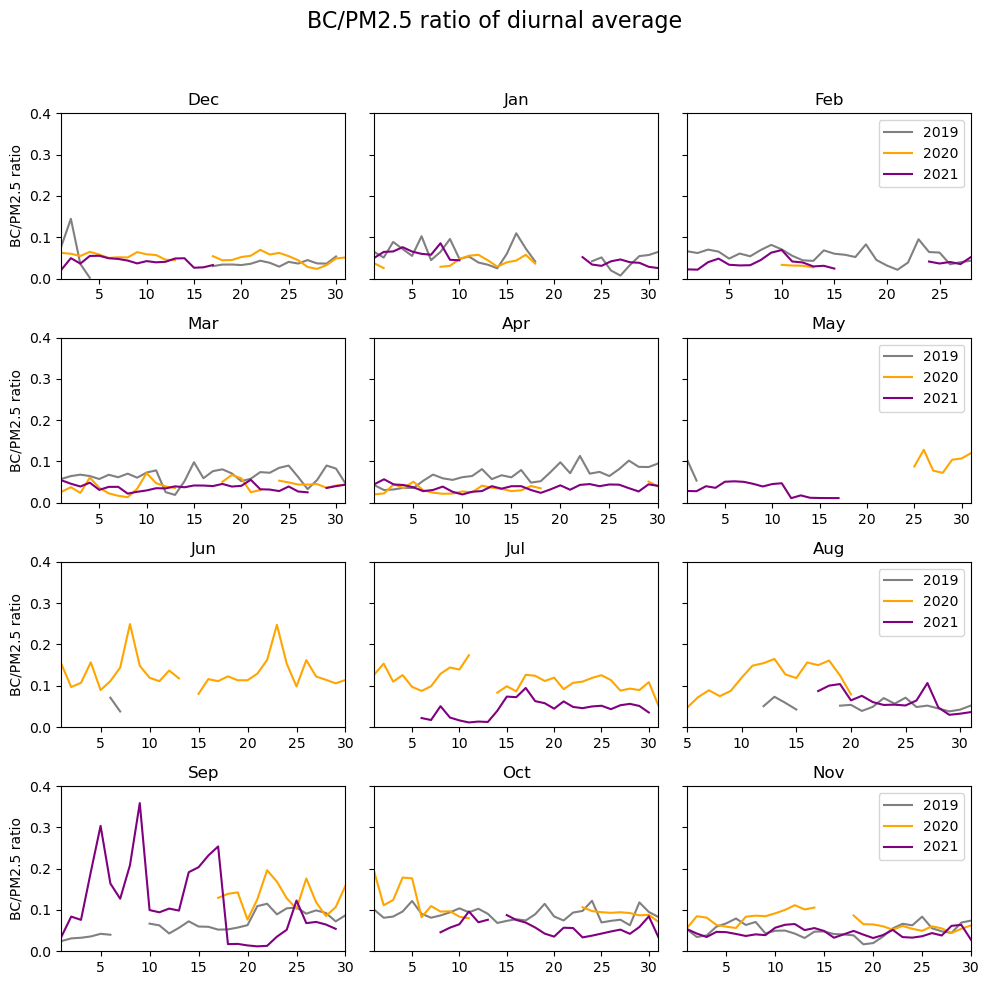

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()
df = pd.concat([df, bc10m], axis=1)

# Calculate BC/PM2.5 ratio
df['BC/PM2.5'] = df['BC'] / df['PM2.5']

# Define years
years = [2019, 2020, 2021]

# Create a dictionary of seasons and months
seasons = {'Winter': ['Dec', 'Jan', 'Feb'],
           'Spring': ['Mar', 'Apr', 'May'],
           'Summer': ['Jun', 'Jul', 'Aug'],
           'Fall': ['Sep', 'Oct', 'Nov']}

# Create subplots for each season
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

for i, (season, months) in enumerate(seasons.items()):
    for j, month in enumerate(months):
        # Resample the data
        data = [df.loc[(df.index.year == year) & (df.index.month == pd.to_datetime(month, format='%b').month)]
                ['BC/PM2.5'].resample('D').mean() for year in years]

        # Plot the data
        colors = ['grey', 'orange', 'purple']
        labels = [f'{year}' for year in years]
        for k, bcpm in enumerate(data):
            axs[i][j].plot(bcpm.index.day, bcpm.values, color=colors[k], label=labels[k])

        # Configure subplot
        axs[i][j].set_title(month)
        axs[i][j].set_ylim(0, 0.4)
        axs[i][j].margins(x=0)
        axs[i][0].set_ylabel('BC/PM2.5 ratio')
        axs[i][1].set_yticklabels([])
        axs[i][2].set_yticklabels([])
        if j == 2:
            axs[i][j].legend(loc='upper right')

# Add main title and adjust layout
fig.suptitle('BC/PM2.5 ratio of diurnal average', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for suptitle
plt.show()


In [33]:
# Separate df['PM2.5'] into high, medium, and low categories
high = df.loc[df[species] > 43.97]
medium = df.loc[(df[species] > 17.7) & (df[species] <= 43.97)]
low = df.loc[df[species] <= 17.7]
df.describe()

,BC,O3,PM2.5,MERRA2-BC,wdir,wspd,temp,prec
count,9195.000000,9195.000000,9195.000000,9195.000000,9195.000000,9195.000000,9195.000000,9195.000000
mean,1.650029,28.773436,36.347716,2.356769,142.473083,1.815117,25.098173,0.146928
std,1.807157,22.960056,29.568762,1.299487,103.257282,1.216757,5.509310,1.451250
min,0.010000,0.000000,0.940000,0.416471,0.000000,0.000000,10.400000,0.000000
25%,0.454212,11.000000,17.703772,1.491717,90.000000,1.000000,21.400000,0.000000
50%,1.130000,23.530000,27.370000,2.137099,135.000000,2.000000,25.500000,0.000000
75%,2.180000,43.385000,43.970000,2.948600,247.500000,3.000000,28.900000,0.000000
max,49.370000,376.250000,296.460000,16.386622,337.500000,6.000000,39.000000,55.700000


# PM2.5

In [15]:
import pandas as pd
# Load SLCP2019daily.csv into a DataFrame
df = pd.read_csv('data/SLCP2019daily.csv', index_col='Tstamp', parse_dates=True)

# Drop PM2.5 na values
df = df.dropna(subset=['BCmean', 'Dpattern'])

# year = 2019
# df = df[df.index.year == year]
# species = 'BCmean'
# df = df[species]
df.head()

,PM2.5mean,BCmean,O3mean,PM2.5max,BCmax,O3max,Dpattern,Precipitation,Tmean,RHmean,Windspeed,WDirection,SunshineHours,China,RRD,SoutheastAsia,PacificOcean
Tstamp,,,,,,,,,,,,,,,,,
2019-01-01,27.261250,1.976667,17.935833,42.41,4.80,25.20,DNV,NaN,11.8,66,6,NNE,0.0,12,16,0,0
2019-01-02,32.336250,1.752083,20.427500,59.95,3.92,39.70,DNV,NaN,13.8,67,5,NNE,0.3,57,19,0,0
2019-01-03,26.924167,2.544583,23.202500,37.56,4.70,48.08,DNV,NaN,15.4,71,4,NNE,3.0,96,28,0,0
2019-01-04,47.764167,3.407083,12.097500,88.91,6.76,39.74,DNV,0.9,16.6,78,3,NNE,0.3,131,41,0,0
2019-01-05,75.191250,4.069583,18.196250,127.30,9.00,66.27,DNV,NaN,19.0,81,5,NNE,0.9,164,56,0,0


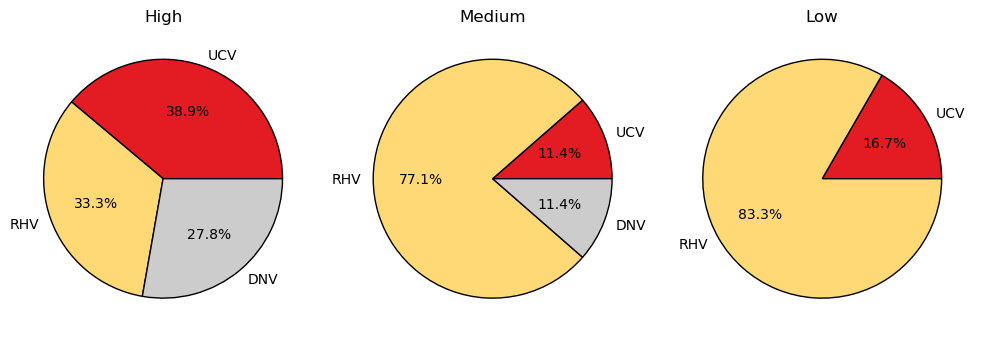

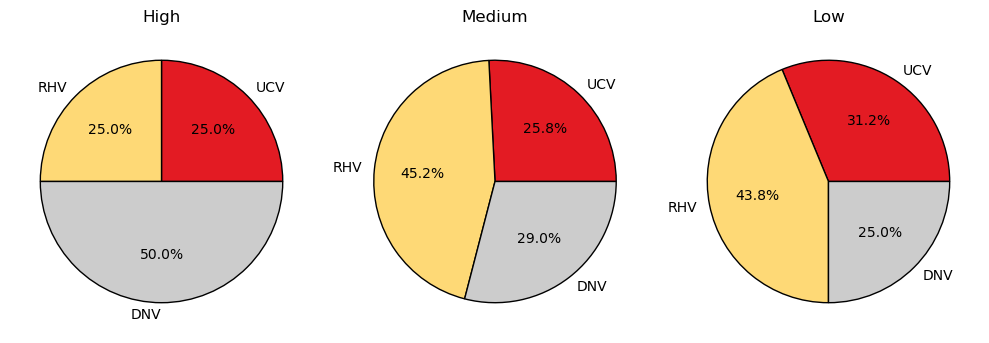

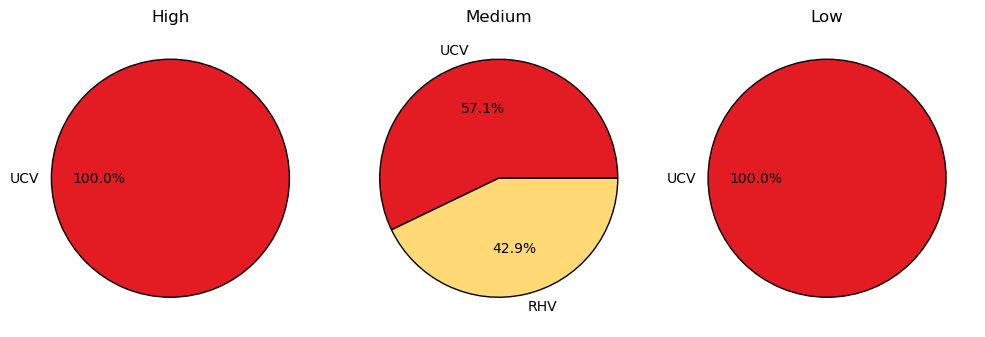

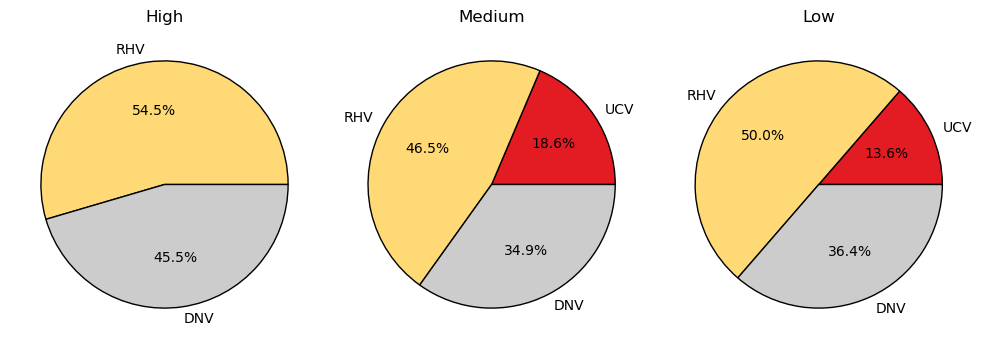

In [16]:
import matplotlib.pyplot as plt

# Mask df_2019['PM2.5'] with each season
winter = df.loc[df.index.month.isin([12, 1, 2])]
spring = df.loc[df.index.month.isin([3, 4, 5])]
summer = df.loc[df.index.month.isin([6, 7, 8])]
fall = df.loc[df.index.month.isin([9, 10, 11])]
seasons = [winter, spring, summer, fall]

# Separate PM2.5 of each season into high, medium, and low dataframes by IQR
for season in seasons:
    first_quartile = season[species].quantile(0.25) # first quartile
    third_quartile = season[species].quantile(0.75) # third quartile
    season_high = season.loc[season[species] > third_quartile]
    season_medium = season.loc[(season[species] > first_quartile) & (season[species] <= third_quartile)]
    season_low = season.loc[season[species] <= first_quartile]

    # Create pie charts for PM2.5 diurnal patterns for each high, medium, low category
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    colors = ['#E31B23', '#FED976', '#CCCCCC']
    labels = ['UCV', 'RHV', 'DNV']
    
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    
    for ax, data, title, color in zip(axs, [season_high, season_medium, season_low], ['High', 'Medium', 'Low'], colors):
        values = data['Dpattern'].value_counts().reindex(labels, fill_value=0)
        # Plot the pie chart
        patches, texts, autotexts = ax.pie(values, labels=values.index, autopct=autopct_format, colors=colors)
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.axis('off')

        # Hide labels and autopct values for patches with 0 percent
        for i, p in enumerate(patches):
            if values[i] == 0:
                texts[i].set_text('')
                autotexts[i].set_text('')
            else:
                # autotexts[i].set_color('white')
                # Set line color of patches to black
                p.set_edgecolor('black')
    plt.tight_layout()
    plt.show()




In [50]:
df.head()

,BC,O3,PM2.5,MERRA2-BC,wdir,wspd,temp,prec,BC/PM2.5
2019-01-01 00:00:00,2.45,16.29,29.85,1.924800,0.0,0.0,11.8,0.0,0.082077
2019-01-01 01:00:00,2.48,14.59,32.77,1.732079,337.5,3.0,11.8,0.0,0.075679
2019-01-01 02:00:00,1.81,15.10,30.55,1.568879,0.0,3.0,11.0,0.0,0.059247
2019-01-01 03:00:00,1.93,15.69,27.14,1.451226,0.0,3.0,11.0,0.0,0.071113
2019-01-01 04:00:00,3.00,16.77,32.37,1.371665,0.0,3.0,11.0,0.0,0.092678


# Seasonal Variations

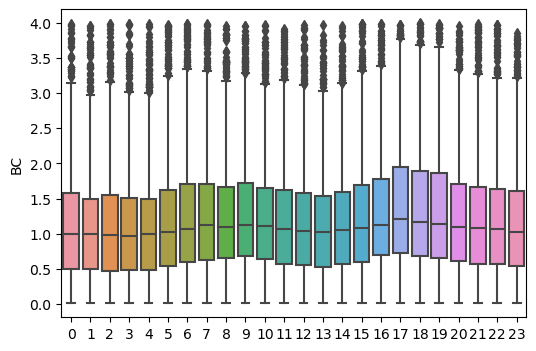

In [16]:
import seaborn as sns
df = df[df['BC']<4]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.boxplot(x=df.index.hour, y=df['BC'], ax=ax, color=None)
plt.show()

# Check PM2.5/BC & Ozone linear regression

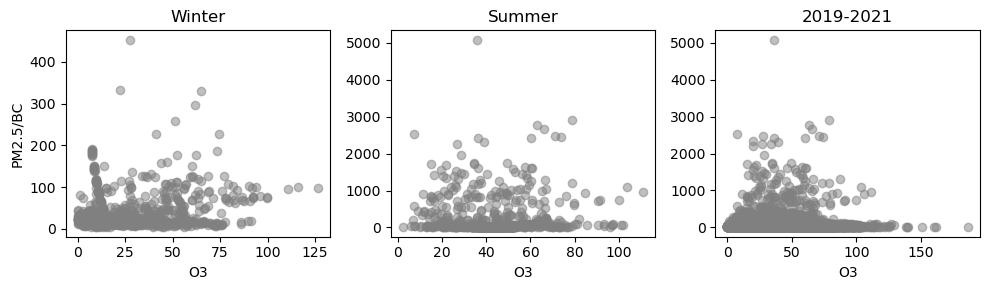

Number of hours when BC is 0 in winter:  0
Number of hours when BC is 0 in summer:  0


In [3]:
# Load SLCP data
import pandas as pd
from pandas import date_range
import matplotlib.pyplot as plt

df = pd.read_csv('slcp_2019-2021.csv', index_col=0, parse_dates=True)
df_2019 = df.loc[df.index.year == 2019]
winter_2019 = df_2019.loc[df_2019.index.month.isin([12, 1, 2])]
summer_2019 = df_2019.loc[df_2019.index.month.isin([6, 7, 8])]
# Select daytime data
winter_2019 = winter_2019.between_time('08:00', '17:00')
summer_2019 = summer_2019.between_time('08:00', '17:00')
df = df.between_time('08:00', '17:00')

# Identify outliers of PM2.5 and BC
winter_2019 = winter_2019.loc[(winter_2019['PM2.5'] < 150) & (winter_2019['BC'] < 10)]
summer_2019 = summer_2019.loc[(summer_2019['PM2.5'] < 150) & (summer_2019['BC'] < 10)]
df = df.loc[(df['PM2.5'] > 0) & (df['BC'] > 0)]

# Plot PM2.5/BC vs O3
fig, ax = plt.subplots(1, 3, figsize=(10,3))
x1 = winter_2019['O3']
y1 = winter_2019['PM2.5']/winter_2019['BC']
ax[0].scatter(x1, y1, color='grey', alpha=0.5)
ax[0].set_xlabel('O3')
ax[0].set_ylabel('PM2.5/BC')
ax[0].set_title('Winter')

x2 = summer_2019['O3']
y2 = summer_2019['PM2.5']/summer_2019['BC']
ax[1].scatter(x2, y2, color='grey', alpha=0.5)
ax[1].set_xlabel('O3')
ax[1].set_title('Summer')

x3 = df['O3']
y3 = df['PM2.5']/df['BC']
ax[2].scatter(x3, y3, color='grey', alpha=0.5)
ax[2].set_xlabel('O3')
ax[2].set_title('2019-2021')

plt.tight_layout()
plt.show()
# Count the number of hours when BC is 0
print('Number of hours when BC is 0 in winter: ', len(df.loc[df['PM2.5'] == 0]))
print('Number of hours when BC is 0 in summer: ', len(df.loc[df['PM2.5'] == 0]))

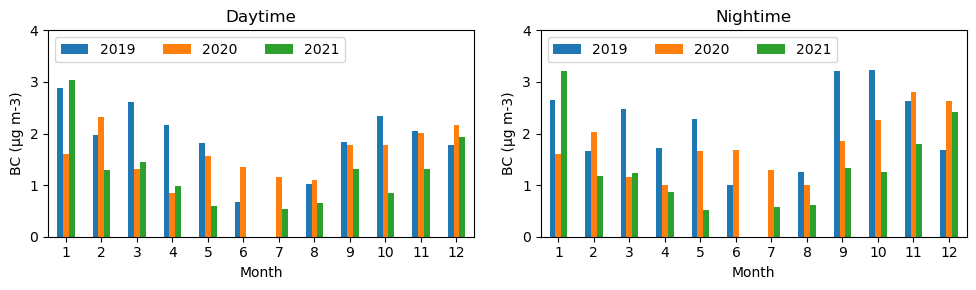

In [35]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)

# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

# Load 10 min BC data
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()

# Concatenate 10 min BC data to df
df = pd.concat([df, bc10m], axis=1)

# Select 2019-2021 data
df = df.loc[df.index.year.isin([2019, 2020, 2021])]

# Separate df into daytime and nightime
df_day = df.between_time('08:00', '18:00')
df_night = df.between_time('18:00', '08:00')

# Plot seasonal PM2.5 data grouped by season with legend as each year
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# df_day.groupby([df_day.index.month, df_day.index.year])['PM2.5'].mean().unstack().plot(kind='bar', ax=ax[0])

# ax[0].tick_params(axis='x', rotation=0) # Set x ticklabels direction
# ax[0].set_ylabel('PM2.5')
# ax[0].set_xlabel('Month')
# ax[0].set_title('Daytime')
# ax[0].legend(loc='upper center')

# df_night.groupby([df_night.index.month, df_night.index.year])['PM2.5'].mean().unstack().plot(kind='bar', ax=ax[1])
# ax[1].tick_params(axis='x', rotation=0)
# ax[1].set_ylabel('PM2.5')
# ax[1].set_xlabel('Month')
# ax[1].set_title('Nightime')

df_day.groupby([df_day.index.month, df_day.index.year])['BC'].mean().unstack().plot(kind='bar', ax=ax[0])
ax[0].tick_params(axis='x', rotation=0)
ax[0].set_ylabel('BC (μg m-3)')
ax[0].set_xlabel('Month')
ax[0].set_ylim(0, 4)
ax[0].set_title('Daytime')


ax[0].legend(loc='upper left', ncol=3)

df_night.groupby([df_night.index.month, df_night.index.year])['BC'].mean().unstack().plot(kind='bar', ax=ax[1])
ax[1].tick_params(axis='x', rotation=0)
ax[1].set_ylabel('BC (μg m-3)')
ax[1].set_xlabel('Month')
ax[1].set_ylim(0, 4)
ax[1].set_title('Nightime')
ax[1].legend(loc='upper left', ncol=3)

plt.tight_layout()
plt.show()





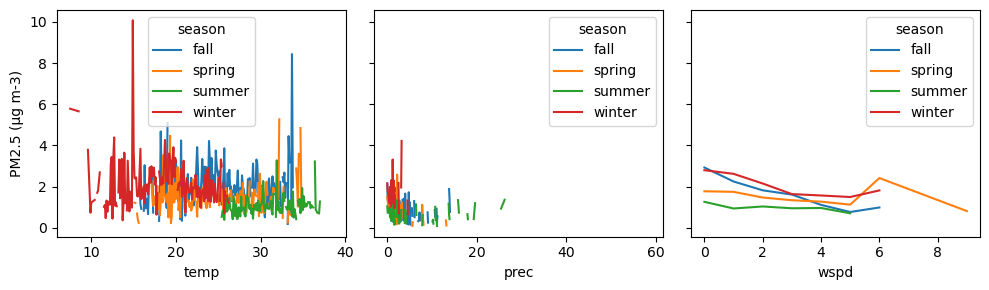

In [8]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
metdata = pd.read_csv('data/metdata_2019-2021.csv', index_col=0, parse_dates=True)
# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

# Load 10 min BC data
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()

# Concatenate 10 min BC data to df
df = pd.concat([df, bc10m], axis=1)
df = df.join(metdata)

# Create season dictionary
season_dict = {12: 'winter', 1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 11: 'fall'}

df['season'] = df.index.month.map(season_dict)

# Select 2019 data
# df = df.loc[df.index.year == 2019]

# Filter rainy days
# df = df.loc[df['prec'] == 0]
# df = df.loc[df['wspd'] < 2]
# Group PM2.5 by temp and season


# Mask rush hour data
# morning_rush = df.between_time('06:00', '09:00')
# evening_rush = df.between_time('16:00', '19:00')
# df = df.loc[~df.index.isin(morning_rush.index) & ~df.index.isin(evening_rush.index)]


# Filter nighttime data
# df = df.between_time('06:00', '18:00')

# Filter daytime data
# df = df.between_time('18:00', '06:00')

# # Group PM2.5 by wspd
# pm_w = df.groupby('wspd')['PM2.5'].mean()
# pm_w = pm_w.reset_index()
# pm_w = pm_w.sort_values(by='wspd')

# # Group PM2.5 by prec
# pm_p = df.groupby('prec')['PM2.5'].mean()
# pm_p = pm_p.reset_index()
# pm_p = pm_p.sort_values(by='prec')

# # Group PM2.5 by temp
# pm_t = df.groupby('temp')['PM2.5'].mean()
# pm_t = pm_t.reset_index()
# pm_t = pm_t.sort_values(by='temp')

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
# pm_t.plot(x='temp', y='PM2.5', kind='line', ax=ax[0], legend=False)
# pm_p.plot(x='prec', y='PM2.5', kind='line', ax=ax[1], legend=False)
# pm_w.plot(x='wspd', y='PM2.5', kind='line', ax=ax[2])

df.groupby([df['temp'], df['season']])['BC'].mean().unstack().plot(kind='line', ax=ax[0])
df.groupby([df['prec'], df['season']])['BC'].mean().unstack().plot(kind='line', ax=ax[1])
df.groupby([df['wspd'], df['season']])['BC'].mean().unstack().plot(kind='line', ax=ax[2])



# Set y label
ax[0].set_ylabel('PM2.5 (μg m-3)')
plt.tight_layout()


In [8]:
df_day.head()

,BC,O3,PM2.5,MERRA2-BC,wdir,wspd,temp,prec
2019-01-01 08:00:00,4.61,14.58,32.40,1.299107,0.0,5.0,12.2,0.0
2019-01-01 09:00:00,1.95,16.60,30.72,1.391255,0.0,5.0,12.2,0.0
2019-01-01 10:00:00,2.15,20.20,27.16,1.601695,0.0,5.0,12.2,0.0
2019-01-01 11:00:00,1.13,22.75,23.65,1.801948,0.0,5.0,12.2,0.0
2019-01-01 12:00:00,0.93,24.86,21.76,1.954104,0.0,5.0,12.2,0.0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)
# Load 10 min BC data
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()

# Concatenate 10 min BC data to df
df = pd.concat([df, bc10m], axis=1)

# Filter data
year = 2021
df = df.loc[df.index.year == year]
species = 'BC'
# species = 'PM2.5'
# df = df.dropna(subset=[species])

# Calculate daily BC mean
df['daily'] = df.groupby(df.index.date)[species].transform('mean')
df['hourly/dailymean'] = df[species] / df['daily']

# Create a 2D array of Monthly average of each local time BC, x axis is month, y axis is hour
bc_mean = df.groupby([df.index.hour, df.index.month])['hourly/dailymean'].mean().unstack()

# Reverse the order of the rows
bc_mean = bc_mean.iloc[::-1]
bc_mean




,1,2,3,4,5,6,7,8,9,10,11,12
23,0.937603,1.154044,0.857876,0.911736,0.850416,NaN,0.911719,0.733380,0.971451,1.099155,1.026816,1.119720
22,1.048133,1.120928,0.926038,0.995204,0.870224,NaN,0.940133,0.843057,1.270302,1.122212,1.154495,1.240568
21,1.205548,1.140564,0.955806,1.075310,0.966085,NaN,1.032577,0.948946,1.056928,1.241312,1.320563,1.329287
20,1.177734,1.242284,0.999357,1.237069,1.000889,NaN,1.100869,1.002875,1.025089,1.275073,1.342110,1.309759
19,1.153860,1.584047,1.075987,1.162913,1.022514,NaN,1.001454,1.039864,1.084745,1.281420,1.370141,1.289916
18,1.162570,1.482235,1.164126,1.110565,1.083896,NaN,1.224930,1.509354,1.031588,1.196666,1.294488,1.220999
17,1.043157,1.341328,1.168812,1.105818,1.148689,NaN,0.894731,1.034824,0.912983,1.138726,1.025815,1.043627
16,0.991594,1.204185,1.179734,1.436876,1.114162,NaN,0.846000,0.912092,0.868482,0.996185,0.845939,0.840594
15,0.914075,0.837335,1.047238,1.018069,1.107832,NaN,0.794822,0.900518,0.849607,0.793763,0.732049,0.732061
14,0.863307,0.700948,0.975088,0.939530,1.020644,NaN,0.808283,0.859582,0.843171,0.720287,0.659488,0.676658


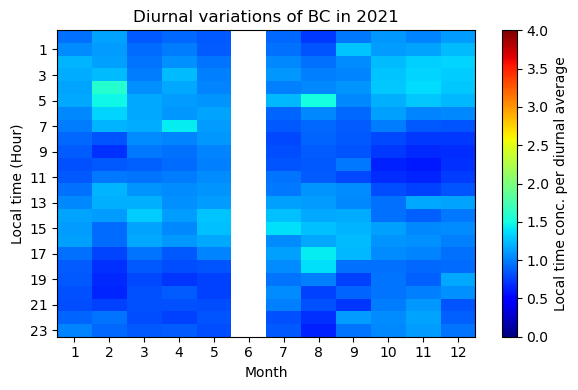

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.imshow(bc_mean, cmap='jet', vmin=0, vmax=4, aspect='auto')
ax.set_xticks(range(0, 12, 1))
ax.set_xticklabels(range(1, 13, 1))
ax.set_yticks(bc_mean.index[::2])
ax.set_yticklabels(bc_mean.index[::2])
ax.set_xlabel('Month')
ax.set_ylabel('Local time (Hour)')
ax.set_title('Diurnal variations of '+ species + ' in ' + str(year))

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax, label='Local time conc. per diurnal average')
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

bc10m = pd.read_csv('data/bc10m.csv', index_col=0, parse_dates=True, header=0, names=['BC'])
bc10m.head()

,BC
2019-01-01 00:04:00,-9.99
2019-01-01 00:14:00,2.55
2019-01-01 00:24:00,1.77
2019-01-01 00:34:00,-9.99
2019-01-01 00:44:00,3.90


In [51]:
data = bc10m[(bc10m['BC']>=0) & (bc10m['BC']<=10)]
# bc = pd.DataFrame(data['BC'].resample('H').mean())

data = data[data.index.year==2020]
data = data[data.index.month==7]
data.tail(30)






,BC


In [22]:
bc.head(10)

,BC
2019-01-01 00:00:00,2.600000
2019-01-01 01:00:00,2.703333
2019-01-01 02:00:00,1.898333
2019-01-01 03:00:00,1.551667
2019-01-01 04:00:00,2.780000
2019-01-01 05:00:00,3.435000
2019-01-01 06:00:00,4.380000
2019-01-01 07:00:00,2.430000
2019-01-01 08:00:00,2.308333
2019-01-01 09:00:00,2.138333


In [134]:
# Load data
import pandas as pd

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)

# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

# Load 10 min BC data
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()

# Concatenate 10 min BC data to df
df = pd.concat([df, bc10m], axis=1)
# Define seasons
winter = df.loc[df.index.month.isin([12, 1, 2])]
spring = df.loc[df.index.month.isin([3, 4, 5])]
summer = df.loc[df.index.month.isin([6, 7, 8])]
fall = df.loc[df.index.month.isin([9, 10, 11])]
seasons = [winter, spring, summer, fall]
years = [2019, 2020, 2021]

# Calculate seasonal BC mean for each year and whole period of 3 years
df = df[df.index.year == 2020]
for season in seasons:
    print(season['BC'].mean())






2.2237819090832702
1.4798154867630888
1.015674749668235
2.055469766209683


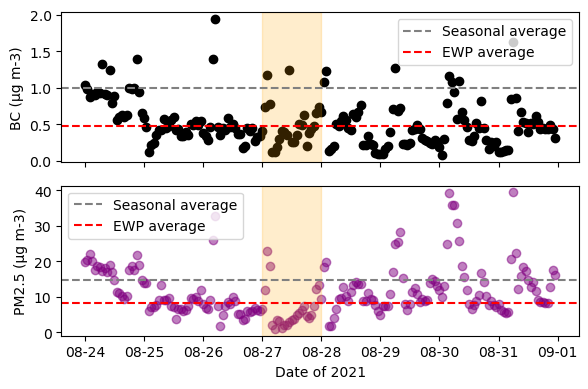

In [156]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)

# Change column name of BC to BC1h
df.rename(columns={'BC': 'BC1h'}, inplace=True)

# Load 10 min BC data
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()

# Concatenate 10 min BC data to df
df = pd.concat([df, bc10m], axis=1)

# # Select period of the 1st lockdown
# df = df.loc['2020-03-21':'2020-04-18']
# lockdown = df.loc['2020-04-01':'2020-04-15']

# # Select period of the 2nd lockdown
# df = df.loc['2021-07-13':'2021-08-10']
# lockdown = df.loc['2021-07-19':'2021-08-01']

# # Select period of Tet 2019
# df = df.loc['2019-01-29':'2019-02-12']
# lockdown = df.loc['2019-02-05':'2019-02-07']

# # Select period of Tet 2020
# df = df.loc['2020-01-21':'2020-02-01']
# lockdown = df.loc['2020-01-25':'2020-01-27']

# # Select period of Tet 2021
# df = df.loc['2021-02-04':'2021-02-19']
# lockdown = df.loc['2021-02-08':'2021-02-10']

# Select period of EWP
df = df.loc['2021-08-24':'2021-08-31']
lockdown = df.loc['2021-08-27':'2021-08-28']

# Plot BC and PM2.5 in scatter plot
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].scatter(df.index, df['BC'], color='black')
ax[1].scatter(df.index, df['PM2.5'], color='purple', alpha=0.5)

# Draw seasonal average line
# df['BC'].resample('D').mean().plot(ax=ax[0], color='red', label='Seasonal average')
# df['PM2.5'].resample('D').mean().plot(ax=ax[1], color='red', label='Seasonal average')

# Draw a line at 1.4 μg m-3
ax[0].axhline(y=1.0, color='grey', linestyle='--', label='Seasonal average')
ax[1].axhline(y=14.7, color='grey', linestyle='--', label='Seasonal average')

# Draw a line of average PM2.5 during lockdown
ax[0].axhline(y=lockdown['BC'].mean(), color='red', linestyle='--', label='EWP average')
ax[1].axhline(y=lockdown['PM2.5'].mean(), color='red', linestyle='--', label='EWP average')

ax[0].set_ylabel('BC (μg m-3)')
ax[1].set_ylabel('PM2.5 (μg m-3)')
ax[0].xaxis.set_ticklabels([])
# Format x axis as mm-dd
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax[1].set_xlabel('Date of 2021')
# Mark the lockdown period
ax[0].axvspan('2021-08-27', '2021-08-28', color='orange', alpha=0.2)
ax[1].axvspan('2021-08-27', '2021-08-28', color='orange', alpha=0.2)
# ax[0].set_ylim(0, 4)
# ax[1].set_ylim(0, 100)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()


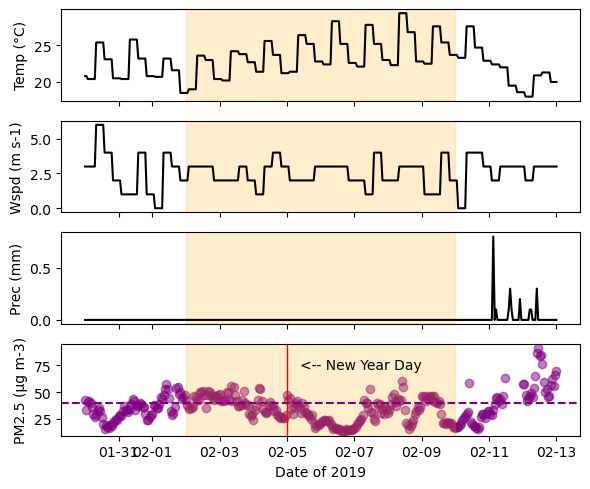

In [118]:
df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
metdata = pd.read_csv('data/metdata_2019-2021.csv', index_col=0, parse_dates=True)

tet2019 = ['2019-02-02', '2019-02-10']
tet2020 = ['2020-01-23', '2020-01-29']
tet2021 = ['2021-02-07', '2021-02-16']

# Select period of Tet holiday
span = tet2019

# Filter data with buffer of 3 days
start = pd.to_datetime(span[0]) - pd.Timedelta(3, "d")
end = pd.to_datetime(span[1]) + pd.Timedelta(3, "d")
df = df.loc[start : end]

metdata = metdata.loc[start:end]

# Plot Temperature, Wind speed, and Precipitation with shared x axis

fig, ax = plt.subplots(4, 1, figsize=(6, 5), sharex=True)
ax[0].plot(metdata.index, metdata['temp'], color='black')
ax[1].plot(metdata.index, metdata['wspd'], color='black')
ax[2].plot(metdata.index, metdata['prec'], color='black')
ax[3].scatter(df.index, df['PM2.5'], color='purple', alpha=0.5)
ax[3].axhline(y=40, color='purple', linestyle='--', label='Seasonal average')

# Highlight the holiday period
for sub_ax in ax:
    sub_ax.axvspan(span[0], span[1], color='orange', alpha=0.2)
    
# Annotate the New Year Day
# ax[3].axvspan('2021-02-12','2021-02-12', color='red')
ax[3].axvspan('2019-02-05','2019-02-05', color='red')
ax[3].annotate('<-- New Year Day',xy=(300, 120), xycoords='figure pixels')

ax[0].set_ylabel('Temp (°C)')
ax[1].set_ylabel('Wspd (m s-1)')
ax[2].set_ylabel('Prec (mm)')
ax[3].set_ylabel('PM2.5 (μg m-3)')

ax[3].set_xlabel('Date of 2019')

ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[2].xaxis.set_ticklabels([])
# Format x axis as mm-dd
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()
plt.show()

In [157]:
print(lockdown['BC'].mean(), lockdown['PM2.5'].mean())

0.47417361111111117 8.247916666666667
